## Imprting all the relevant libraries

In [39]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

## Reading and Transforming the data for further Modeling

In [2]:
# Reading the files to a DataFrame

df_DEMO_J = pd.read_sas("DEMO_J.XPT", format='xport') #demographic data
df_DPQ_J = pd.read_sas("DPQ_J.XPT", format='xport') #depression screener data
df_BMX_J = pd.read_sas("BMX_J.XPT", format='xport') #body measures data
df_BPQ_J = pd.read_sas("BPQ_J.XPT", format='xport') #blood pressure & cholestrol data
df_BPX_J = pd.read_sas("BPX_J.XPT", format='xport') #blood pressure data
df_DIQ_J = pd.read_sas("DIQ_J.XPT", format='xport') #Diabetes data
df_GLU_J = pd.read_sas("GLU_J.XPT", format='xport') #Plasma Fasting Glucose data
df_CDQ_J = pd.read_sas("CDQ_J.XPT", format='xport') #Cardiovascular Health data
df_MCQ_J = pd.read_sas("MCQ_J.XPT", format='xport') #Medical Conditions data

In [3]:
# Choosing all the relevant columns only

df_demo = df_DEMO_J[['SEQN','RIDAGEYR','RIAGENDR','RIDRETH3','DMDEDUC3','DMDEDUC2','INDHHIN2']] #Demograph
df_demo = df_demo[df_demo['RIDAGEYR']>=20] #Choosing only Adults users

df_bmi = df_BMX_J[['SEQN','BMXBMI']] # Obesity
df_bpq = df_BPQ_J[['SEQN','BPQ020','BPQ030','BPQ040A','BPQ050A']] # Hypertension
df_bpx = df_BPX_J[['SEQN','BPXSY1','BPXSY2','BPXSY3','BPXSY4','BPXDI1','BPXDI2','BPXDI3','BPXDI4']] # Hypertension
df_diq = df_DIQ_J[['SEQN','DIQ010','DID040','DIQ050','DIQ070','DIQ175I','DIQ175T','DIQ175U','DIQ175V','DIQ280']] # Diabetes
df_glu = df_GLU_J[['SEQN','LBXGLU','LBDGLUSI']] # Diabetes
df_dpq = df_DPQ_J[['SEQN','DPQ020','DPQ010','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090','DPQ100']] # Depression
df_cdq = df_CDQ_J[['SEQN','CDQ001', 'CDQ002', 'CDQ003', 'CDQ004', 'CDQ005', 'CDQ006', 'CDQ008','CDQ009D','CDQ009E', 'CDQ009F', 'CDQ009G', 'CDQ010']] #CVD
df_mcq = df_MCQ_J[['SEQN','MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F','MCQ010','MCQ035','MCQ040','MCQ050']] # Multiple diseases

In [4]:
# Combining all the datapoints into 1 DataFrame

df = df_demo
df = df.merge(df_bmi, on='SEQN', how='left')
df = df.merge(df_bpq, on='SEQN', how='left')
df = df.merge(df_bpx, on='SEQN', how='left')
df = df.merge(df_diq, on='SEQN', how='left')
df = df.merge(df_glu, on='SEQN', how='left')
df = df.merge(df_dpq, on='SEQN', how='left')
df = df.merge(df_cdq, on='SEQN', how='left')
df = df.merge(df_mcq, on='SEQN', how='left')

print("Number of users:", df['SEQN'].nunique())

Number of users: 5569


In [5]:
# Export df to a CSV file for record keeping

df.to_csv('disease_clustering_input_data.csv', index=False)

In [6]:
# Defining binary variable for whether a user has Hypertension

def has_hypertension(row):
    # Checking self-reported data first
    if row['BPQ020'] == 1 or row['BPQ030'] == 1 or row['BPQ040A'] == 1 or row['BPQ050A'] == 1:
        return 1
    
    # Checking clinical blood pressure readings: Systolic >= 130 or Diastolic >= 80
    systolic_bp = [row['BPXSY1'], row['BPXSY2'], row['BPXSY3'], row['BPXSY4']]
    diastolic_bp = [row['BPXDI1'], row['BPXDI2'], row['BPXDI3'], row['BPXDI4']]
    
    if any(bp >= 130 for bp in systolic_bp) or any(bp >= 80 for bp in diastolic_bp):
        return 1
    
    return 0

# Applying the function
df['Has_Hypertension'] = df.apply(has_hypertension, axis=1)

In [8]:
# Defining binary variable for whether a user has Diabetes

def has_diabetes(row):
    # Checking self-reported data first
    if row['DIQ010'] == 1 or pd.notna(row['DID040']) or row['DIQ050'] == 1 or row['DIQ070'] == 1:
        return 1
    
    # Checking clinical blood sugar levels
    if row['LBXGLU'] >= 126 or row['LBDGLUSI'] >= 7.0 or row['DIQ280'] >= 6.5:
        return 1
    
    # Checking for exact symptoms
    if row['DIQ175I'] == 1 or row['DIQ175T'] == 1 or row['DIQ175U'] == 1 or row['DIQ175V'] == 1:
        return 1
    
    return 0

# Applying the function
df['Has_Diabetes'] = df.apply(has_diabetes, axis=1)

In [9]:
# Defining binary variable for whether a user has Obesity

def has_obesity(row):
    # Using BMI as indicator for obesity
    if row['BMXBMI'] >= 30: 
        return 1
    
    return 0

# Applying the function
df['Has_Obesity'] = df.apply(has_obesity, axis=1)

In [10]:
# Defining binary variable for whether a user has CVD

def has_cvd(row):
    # Checking for symptoms of angina
    if (row['CDQ001'] == 1 and 
        row['CDQ002'] == 1 and 
        row['CDQ004'] == 1 and 
        row['CDQ005'] == 1 and 
        row['CDQ006'] == 1 and 
        ((row['CDQ009D'] == 4 or 
        row['CDQ009E'] == 5) or
        (row['CDQ009F'] == 6 and 
        row['CDQ009G'] == 7))):
        return 1
    
    # Checking for history of serious cardiovascular conditions
    if (row['MCQ160B'] == 1 or 
        row['MCQ160C'] == 1 or 
        row['MCQ160D'] == 1 or 
        row['MCQ160E'] == 1 or 
        row['MCQ160F'] == 1):
        return 1
    
    return 0

# Applying the function 
df['Has_CVD'] = df.apply(has_cvd, axis=1)

In [19]:
# Defining binary variable for whether a user has Asthma

def has_asthma(row):
    # Checking for history and present status of Asthma
    if row['MCQ010'] == 1 and (row['MCQ035'] == 1 or row['MCQ040'] == 1 or row['MCQ050'] == 1):
        return 1
    
    return 0

# Applying the function 
df['Has_Asthma'] = df.apply(has_asthma, axis=1)

In [12]:
# Defining binary variable for whether a user has Depression
def has_depression(row):
    # Checking for serious depression symptoms 
    if row['DPQ020'] in (1,2,3):
        return 1
    
    return 0

# Applying the function
df['Has_Depression'] = df.apply(has_depression, axis=1) # Note that this is not used going further

In [13]:
df.groupby('Has_Diabetes')['SEQN'].count()

Has_Diabetes
0    4513
1    1056
Name: SEQN, dtype: int64

In [15]:
df.groupby('Has_Hypertension')['SEQN'].count()

Has_Hypertension
0    2055
1    3514
Name: SEQN, dtype: int64

In [16]:
df.groupby('Has_Obesity')['SEQN'].count()

Has_Obesity
0    3398
1    2171
Name: SEQN, dtype: int64

In [17]:
df.groupby('Has_CVD')['SEQN'].count()

Has_CVD
0    4786
1     783
Name: SEQN, dtype: int64

In [20]:
df.groupby('Has_Asthma')['SEQN'].count()

Has_Asthma
0    5054
1     515
Name: SEQN, dtype: int64

In [21]:
df.groupby('Has_Depression')['SEQN'].count()

Has_Depression
0    4399
1    1170
Name: SEQN, dtype: int64

In [38]:
# Selecting only the binary variables for chronic diseases
df_disease = df[['Has_Hypertension', 'Has_Diabetes', 'Has_CVD', 'Has_Obesity', 'Has_Asthma']]

scaler = StandardScaler()
df_disease_scaled = scaler.fit_transform(df_disease)

## KMeans Clustering

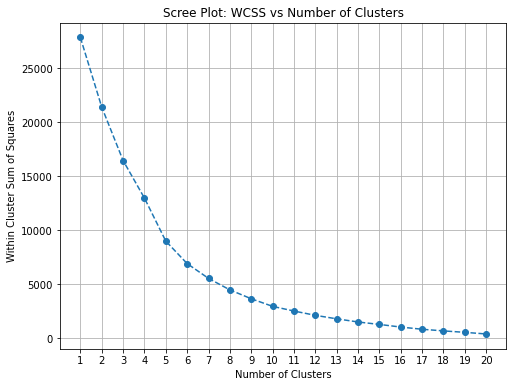

In [23]:
# Plotting a Scree plot for Within Cluster Sum of Squares against Number of Clusters
wcss = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_disease_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('Scree Plot: WCSS vs Number of Clusters')
plt.xticks(range(1, 21))
plt.grid(True)
plt.show()

In [24]:
# Using a Knee/Elbow locator function to detect ideal no. of clusters

from kneed import KneeLocator

clusters = range(1, len(wcss) + 1)

knee_locator = KneeLocator(clusters, wcss, curve="convex", direction="decreasing")
elbow_point = knee_locator.knee

print(f"The elbow point is at {elbow_point} clusters.")

The elbow point is at 6 clusters.


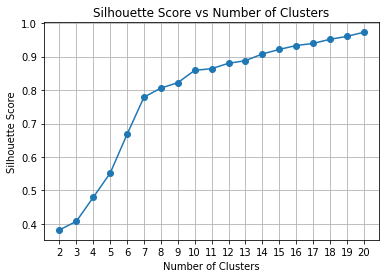

In [28]:
# Using the Silhouette score to detect optimal no. of clusters

silhouette_scores = []
range_n_clusters = range(2, 21)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_disease_scaled)
    silhouette_avg = silhouette_score(df_disease_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores for each no. of clusters
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

Number of clusters = 7 gives us a silhouette score of 77.8% indicating a strong clustering structure in our data

In [31]:
# Fitting the K-Means model with number of clusters k=7

kmeans = KMeans(n_clusters=7, random_state=2024)
df['cluster_kmeans'] = kmeans.fit_predict(df_disease_scaled)

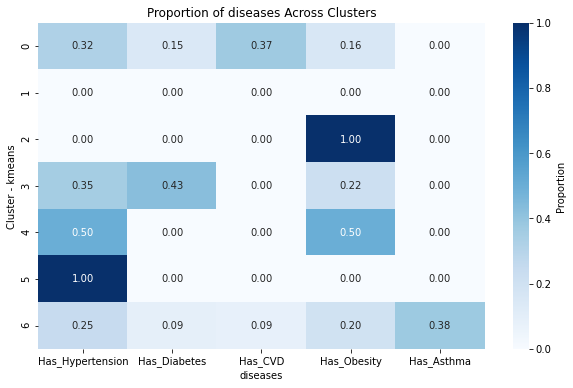

In [48]:
diseases = ['Has_Hypertension', 'Has_Diabetes', 'Has_CVD', 'Has_Obesity', 'Has_Asthma']

df_heatmap = df.groupby('cluster_kmeans')[diseases].sum()
df_heatmap_proportions = df_heatmap.div(df_heatmap.sum(axis=1), axis=0)
df_heatmap_proportions.fillna(0, inplace=True)

# Plotting the heatmap of clusters
plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap_proportions, annot=True, cmap='Blues', fmt=".2f", cbar_kws={'label': 'Proportion'})
plt.title('Proportion of diseases Across Clusters')
plt.xlabel('diseases')
plt.ylabel('Cluster - kmeans')
plt.show()

In [36]:
profiles = []
for cluster in df_heatmap.index:
    cluster_data = df_heatmap.loc[cluster]
    significant_conditions = cluster_data[cluster_data > 0].index.tolist()
    profiles.append(f"Cluster {cluster} is characterized by: {', '.join(significant_conditions)}")

for profile in profiles:
    print(profile)

Cluster 0 is characterized by: Has_Hypertension, Has_Diabetes, Has_CVD, Has_Obesity
Cluster 1 is characterized by: 
Cluster 2 is characterized by: Has_Obesity
Cluster 3 is characterized by: Has_Hypertension, Has_Diabetes, Has_Obesity
Cluster 4 is characterized by: Has_Hypertension, Has_Obesity
Cluster 5 is characterized by: Has_Hypertension
Cluster 6 is characterized by: Has_Hypertension, Has_Diabetes, Has_CVD, Has_Obesity, Has_Asthma


## Hierarchical Clustering

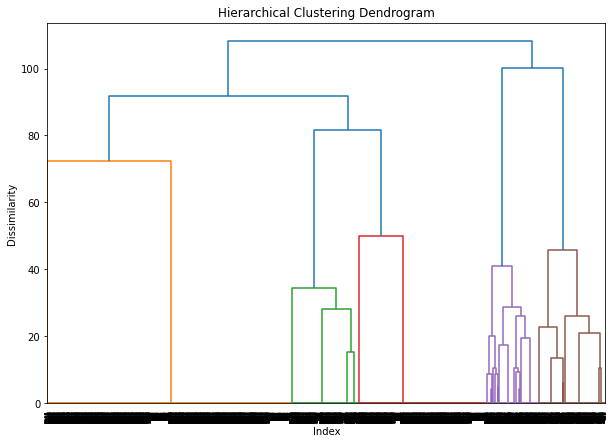

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Hierarchical clustering
dend = linkage(df_disease_scaled, method='ward')

# Plotting the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(dend)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Dissimilarity')
plt.show()

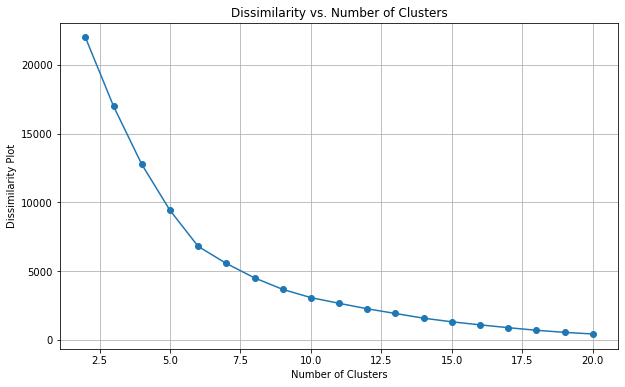

In [47]:
# Calculating dissimilarity for different numbers of clusters

dissimilarities = []
for n_clusters in range(2, 21):
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    hierarchical.fit(df_disease_scaled)

    cluster_labels = hierarchical.labels_
    
    dissimilarity = 0
    for cluster in range(n_clusters):
        cluster_points = df_disease_scaled[cluster_labels == cluster]
        centroid = np.mean(cluster_points, axis=0)
        dissimilarity += np.sum((cluster_points - centroid) ** 2)
    
    dissimilarities.append(dissimilarity)

# Plotting dissimilarity against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), dissimilarities, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dissimilarity Plot')
plt.title('Dissimilarity vs. Number of Clusters')
plt.grid(True)
plt.show()

The rate of change of dissimilarity slows down at 7, indicating that, here as well, the optimal number od clusters is 7

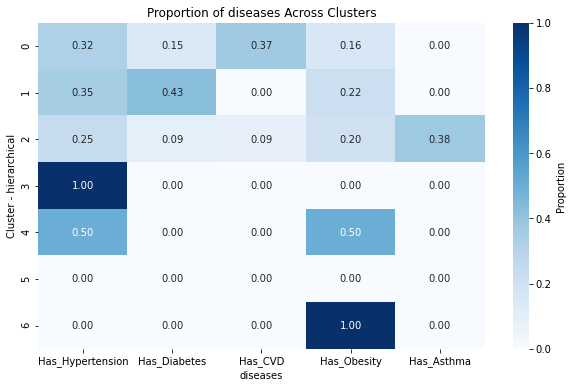

In [49]:
# Hierarchical clustering with number of clusters n_clusters=7
hierarchical = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
df['cluster_hierarchical']  = hierarchical.fit_predict(df_disease_scaled)

df_heatmap_hc = df.groupby('cluster_hierarchical')[diseases].sum()
df_heatmap_hc_proportions = df_heatmap_hc.div(df_heatmap_hc.sum(axis=1), axis=0)
df_heatmap_hc_proportions.fillna(0, inplace=True)

# Plotting the heatmap of clusters
plt.figure(figsize=(10, 6))
sns.heatmap(df_heatmap_hc_proportions, annot=True, cmap='Blues', fmt=".2f", cbar_kws={'label': 'Proportion'})
plt.title('Proportion of diseases Across Clusters')
plt.xlabel('diseases')
plt.ylabel('Cluster - hierarchical')
plt.show()

In [51]:
profiles = []
for cluster in df_heatmap_hc.index:
    cluster_data = df_heatmap_hc.loc[cluster]
    significant_conditions = cluster_data[cluster_data > 0].index.tolist()
    profiles.append(f"Cluster {cluster} is characterized by: {', '.join(significant_conditions)}")

# Output the cluster profiles
for profile in profiles:
    print(profile)

Cluster 0 is characterized by: Has_Hypertension, Has_Diabetes, Has_CVD, Has_Obesity
Cluster 1 is characterized by: Has_Hypertension, Has_Diabetes, Has_Obesity
Cluster 2 is characterized by: Has_Hypertension, Has_Diabetes, Has_CVD, Has_Obesity, Has_Asthma
Cluster 3 is characterized by: Has_Hypertension
Cluster 4 is characterized by: Has_Hypertension, Has_Obesity
Cluster 5 is characterized by: 
Cluster 6 is characterized by: Has_Obesity
